####This is cat vs. dog classification, we use the image_dataset_from_directory utility to generate the datasets, and we use Keras image preprocessing layers for image standardization and data augmentation. 



##imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os

##Detect GPU or TPU

In [4]:
print("Tensorflow version " + tf.__version__)

try: 
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()
print("Number of accelerators: ", strategy.num_replicas_in_sync)

plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)

Tensorflow version 2.6.0
Number of accelerators:  1


##load data

In [5]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   168M      0  0:00:04  0:00:04 --:--:--  173M


In [6]:
!unzip -q kagglecatsanddogs_3367a.zip

In [7]:
!ls

 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [8]:
os.listdir('PetImages')

['Dog', 'Cat']

##Filter out corrupted images

In [9]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


##Generate a dataset

In [10]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


##Visualize the data

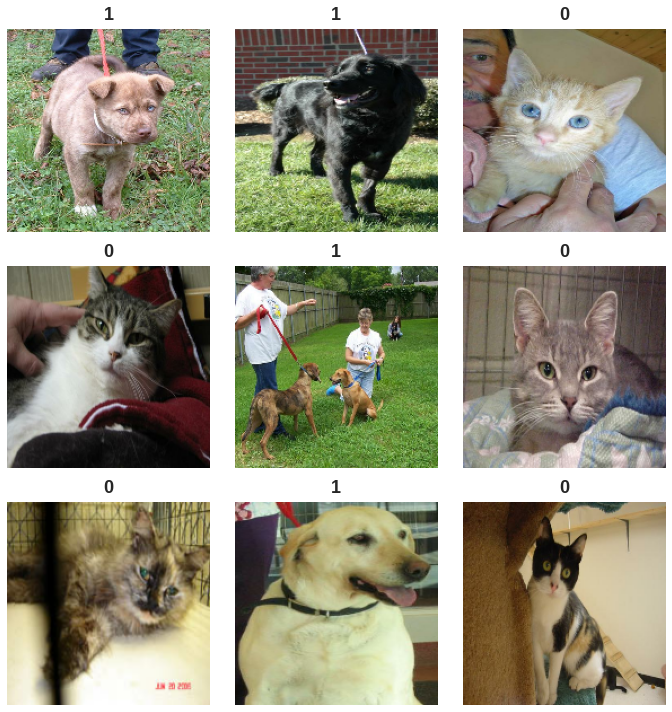

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

##data augmentation

In [12]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

##Visualize the augmenteated pics

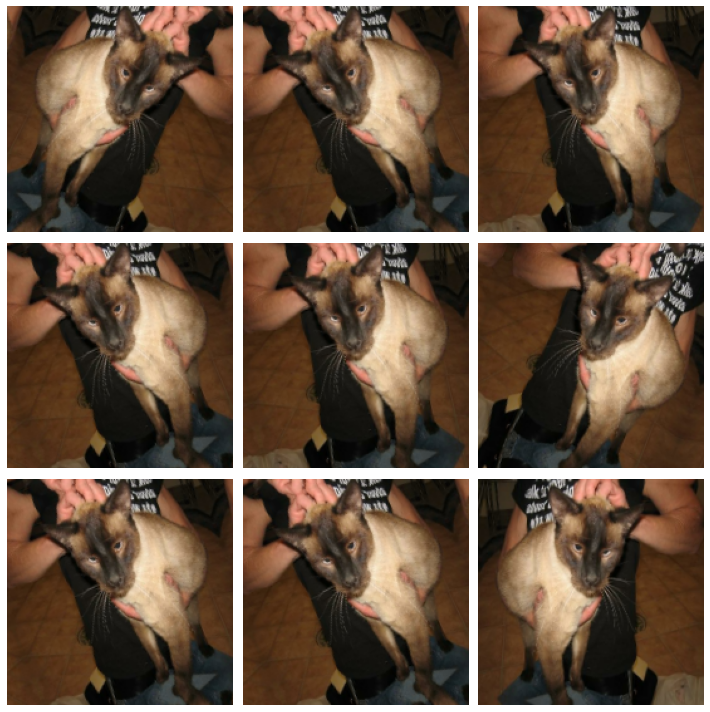

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#####Let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [14]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

##create model

In [18]:
rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255)
])

model = keras.Sequential([
  rescale,
  data_augmentation,
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.BatchNormalization(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(1,activation='sigmoid')
])

##Train model

In [22]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
586/586 [==============================] - 1410s 2s/step - loss: 0.6002 - accuracy: 0.7043 - val_loss: 0.6893 - val_accuracy: 0.6457
Epoch 2/50
586/586 [==============================] - 1427s 2s/step - loss: 0.4939 - accuracy: 0.7576 - val_loss: 0.5202 - val_accuracy: 0.7330
Epoch 3/50
586/586 [==============================] - 1432s 2s/step - loss: 0.4398 - accuracy: 0.7930 - val_loss: 0.4584 - val_accuracy: 0.7798
Epoch 4/50
586/586 [==============================] - 1450s 2s/step - loss: 0.4030 - accuracy: 0.8171 - val_loss: 0.4081 - val_accuracy: 0.8131
Epoch 5/50
586/586 [==============================] - 1452s 2s/step - loss: 0.3700 - accuracy: 0.8356 - val_loss: 0.4077 - val_accuracy: 0.8182
Epoch 6/50
 63/586 [==>...........................] - ETA: 20:23 - loss: 0.3449 - accuracy: 0.8586

KeyboardInterrupt: ignored

In [23]:
!ls

 kagglecatsanddogs_3367a.zip   PetImages        save_at_1.h5   save_at_4.h5
 model.png		      'readme[1].txt'   save_at_2.h5   save_at_5.h5
'MSR-LA - 3467.docx'	       sample_data      save_at_3.h5


In [29]:
model.load_weights('save_at_5.h5')

In [32]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 98.35 percent cat and 1.65 percent dog.


In [35]:
predictions

array([[0.01646617]], dtype=float32)

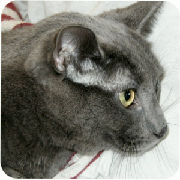

In [33]:
img